# Selfish Routing with Positive Externalities

## Introduction

We consider random networks in which multiple agents with heterogeneous sources and destinations determine their own routes as a best reply to others best replies, the nash equilibrium, that is obtained from an initial state where all agents choose their route on an empty network. 

There are two primary questions we are interested in learning in the simulations. The firt being, how bad can a graph in terms of the social cost of the Waldrop equilibrium of the full graph versus that of its optimal subgraph. The second is whether or not a greedy algorithm can approximate the results of the exhaustive search, which would indicate that this problem might be submodular in the edges removed. 

These simulations are computationally expensive, as an exhaustive search is needed to prove the best possible subgraph, however even these crude initial explorations serve as extremely informative regarding these two primary questions in better understanding the nature of this problem. 

## Setup & Background

We define some core concepts related to the questions we are exploring in the simulations:

### Wardrop Equilibrium

We first define a Wardrop equilibrium, which simply says that given a certain flow $\textit{f}$, and cost function along a path $c_{\mathcal{P}}: \mathcal{P} \rightarrow \mathcal{R}^+$, the cost of every equilibrium path is a equal, and less than the cost along any non-equilibrium path:

$$
c_{\mathcal{P}}(\textit{f}) \leq c_{\widetilde{\mathcal{P}}}(\textit{f} )
$$

### Social Cost

Given multiple sources $S$, multiple agents $A$, a shared destination $t$, and convex and non-decreasing cost function $c(e, f)$, shared up to the paramaterized constant $e$ by each edge (which we can consider to be the distance between two edges in some sort of measure external to the traffic on the network, such as the physical distance of a road), the social cost, $\Gamma$, for a given graph $G$, at Wardrop equilibrium is given by:

$$
C(G) = \sum_{a \in A} d(S_a, t)
$$

Where distance function d(s,t) is defined as the distance along the shortest path, $p(s,t)$, between s and t:

$$
d(s,t) = \sum_{e \in p(s,t)} c(e,f)
$$

### Selfish Ratio

Now we can define Selfish Ratio, namely the ratio between the Wardrop equilibrium of the full network, to that of its optimal subnetwork:

$$
\beta (G, r, c) = \max_{H \subset G} \frac{C(\textit{f})}{C(\textit{f}^H)}
$$


## Code for Simulation

All code can be run via a Jupyter Notebook via the official Jupyter Docker stacks, [scipy-notebook](https://github.com/jupyter/docker-stacks/tree/master/scipy-notebook). The code can be found in the /lib folder of the same repository as this notebook. Note that it is parallelized and best run on a machine with many cores, the current simulations take ~2 hours on a machine with 32 cores. 

In [ ]:
!conda uninstall --yes networkx
!pip install --upgrade git+git://github.com/networkx/networkx.git#egg=networkx
!pip install ggplot

In [29]:
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ggplot import *

# Our code 
from lib.equilibrium import *
from lib.generation import *

In [4]:
def random_distances(graph, bottom = 0.5, top = 2, mult = 1):
    n = graph.shape[0]
    rands = (np.random.uniform(bottom,top,n**2).reshape((n,n))*mult)
    return graph * rands

def base_setup(edges, n, A, cost_fn):
    agents = random_placements(n, A)
    graph = random_distances(path_to_mat(edges, n))
    edges = list(nx.DiGraph(graph).edges(data=True))
    state = initial_state(agents, graph)
    new_state = find_equilibrium(state, graph, cost_fn)
    graphs = [path_to_mat(c, n) for c in combinations(edges)]
    return new_state, graph, graphs, cost_fn

def barabasi(n, attch):
    edges = nx.barabasi_albert_graph(n, attch).edges()
    return list(edges) + map(lambda t: (t[1],t[0]), edges)

def erdos(n, p):
    return list(nx.erdos_renyi_graph(n, p, directed = True).edges())

def full(n):
    adj = np.ones((n,n))
    return list(nx.DiGraph(adj).edges())

def run_one(state, full_graph, graphs, cost_fn, iters = 100):
    return [
        score_graph(state, full_graph, cost_fn), 
        find_optimum_subgraph(state, full_graph, cost_fn, iters)[0],
        combinatorial_optimum(state, graphs, cost_fn)[0],
        float((full_graph != 0).sum())/(full_graph.shape[0]**2) # sparsity
    ]

def run(m, n, A, cost_fn, setup, args):
    def run_model():
        try: 
            return run_one(*base_setup(setup(n, *args), n, A, cost_fn))
        except nx.exception.NetworkXNoPath:
            return None
        
    res = [run_model() for _ in range(m)]
    res = [r for r in res if r is not None]
    df = pd.DataFrame(np.array(res), 
                      columns = ["original", "greedy", "exhaustive", "sparsity"])
    return df.assign(generator = setup.__name__, 
                     generator_param = args[0],
                     cost = cost_fn.__name__)



### Cost Functions

We examine two cost functions, one linear, one exponential, both convex and decreasing in their parametarized flow. 

In [5]:
def linear_cost(f,c):
    return c * 1/f if f > 0 else float('inf')

def exp_cost(f,c):
    return c * (.5)**(f - 1)

# Simulations

5 nodes, 8 agents, random networks generated via Barabasi-Albert and Erdos Renyi with various parameters. We run 20 simulations with each set of parameters. 

In [ ]:
df = pd.concat([
    run(20, 5, 8, linear_cost, erdos, args = [.8]),
    run(20, 5, 8, exp_cost, erdos, args = [.8]),
    run(20, 5, 8, linear_cost, barabasi, args = [3]),
    run(20, 5, 8, exp_cost, barabasi, args = [3]),
    run(20, 5, 8, linear_cost, erdos, args = [.5]),
    run(20, 5, 8, exp_cost, erdos, args = [.5]),
    run(20, 5, 8, linear_cost, barabasi, args = [2]),
    run(20, 5, 8, exp_cost, barabasi, args = [2])
    ], ignore_index = True)

## Selfish Ratio

These initial simulations don't allow us to bound the Selfish Ratio, but they do show that there is very often some inefficiency in the network, but that inefficiency is rarely very large. 

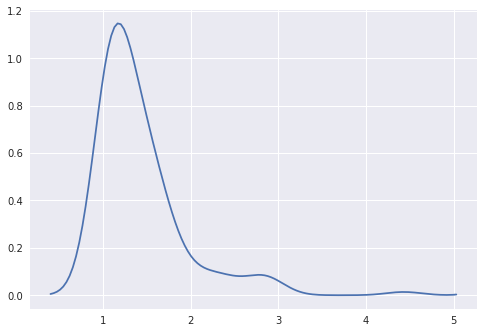

In [38]:
ratio = df.original/df.exhaustive
p = sns.kdeplot(ratio, bw = .2)

## $\epsilon$-Approximation Error of Greedy Algorithm

From the results of this initial simulation, it is clear that we can't necessarily bound the lower end of the Greedy algorithm, it is not clear that it cannot be arbitrarily bad given a particular network structure. We can, however, see clearly that in these particular networks tested, it finds a perfect solution a large percentage of the time, which is also very interesting. 

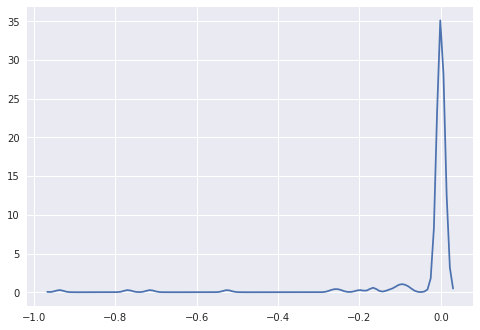

In [39]:
epsilon = (df.exhaustive - df.greedy)/df.exhaustive
p = sns.kdeplot(epsilon, bw = .01)

In [40]:
np.min(epsilon)

-0.9375

## Selfish Ratio as a Function of Sparsity

We will need more simulations to conclude anything with regards to this relationship. Theory points us to the selfish ratio being worse the more full the graph is, however we do not see evidence of that in these limited simulations.

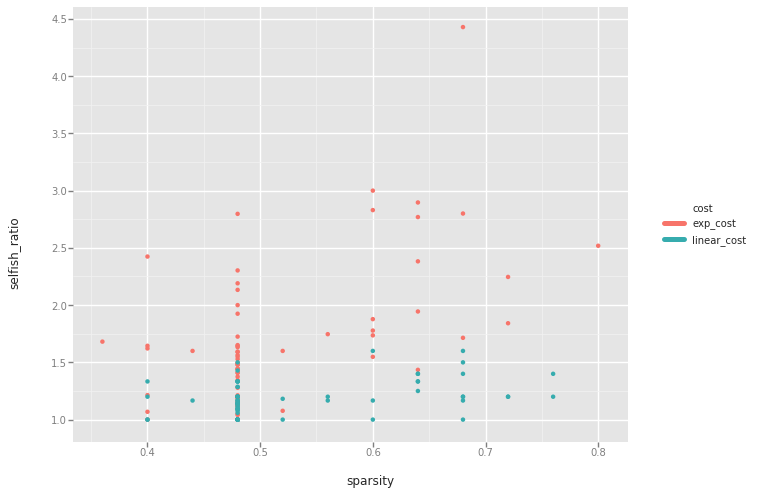

<ggplot: (8742600837113)>

In [41]:
df = df.assign(selfish_ratio = df.original/df.exhaustive)

p = ggplot(df, aes(x = "sparsity", y = "selfish_ratio", color = "cost")) + geom_point()

## Raw Results

In [42]:
df

,original,greedy,exhaustive,sparsity,cost,generator,generator_param,selfish_ratio
0,6.0000,5.000000,5.000000,0.72,linear_cost,erdos,0.8,1.200000
1,8.0000,6.000000,6.000000,0.64,linear_cost,erdos,0.8,1.333333
2,5.0000,5.000000,5.000000,0.68,linear_cost,erdos,0.8,1.000000
3,9.0000,6.000000,6.000000,0.68,linear_cost,erdos,0.8,1.500000
4,8.0000,6.000000,5.000000,0.68,linear_cost,erdos,0.8,1.600000
5,6.0000,5.000000,5.000000,0.68,linear_cost,erdos,0.8,1.200000
6,7.0000,5.000000,5.000000,0.64,linear_cost,erdos,0.8,1.400000
7,6.0000,5.000000,5.000000,0.76,linear_cost,erdos,0.8,1.200000
8,7.0000,5.000000,5.000000,0.64,linear_cost,erdos,0.8,1.400000
9,6.0000,5.000000,5.000000,0.68,linear_cost,erdos,0.8,1.200000
